# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103385 entries, 0 to 103384
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        103385 non-null  int64 
 1   Title             103385 non-null  object
 2   Product Name      103385 non-null  object
 3   Length            103385 non-null  int64 
 4   Language          103385 non-null  object
 5   Title_Processed   103385 non-null  object
 6   Title_Translated  103385 non-null  object
 7   Tags              103385 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11488 entries, 0 to 11487
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        11488 non-null  int64 
 1   Title             11488 non-null  object
 2   Product Name      11488 non-null  object
 3   Length            1148

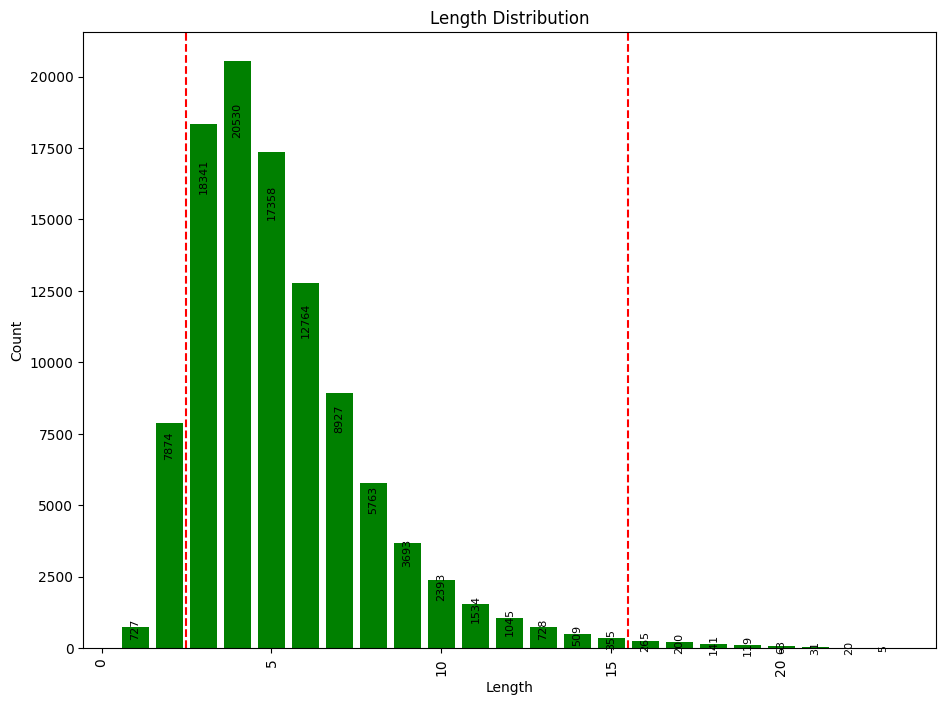

In [2]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

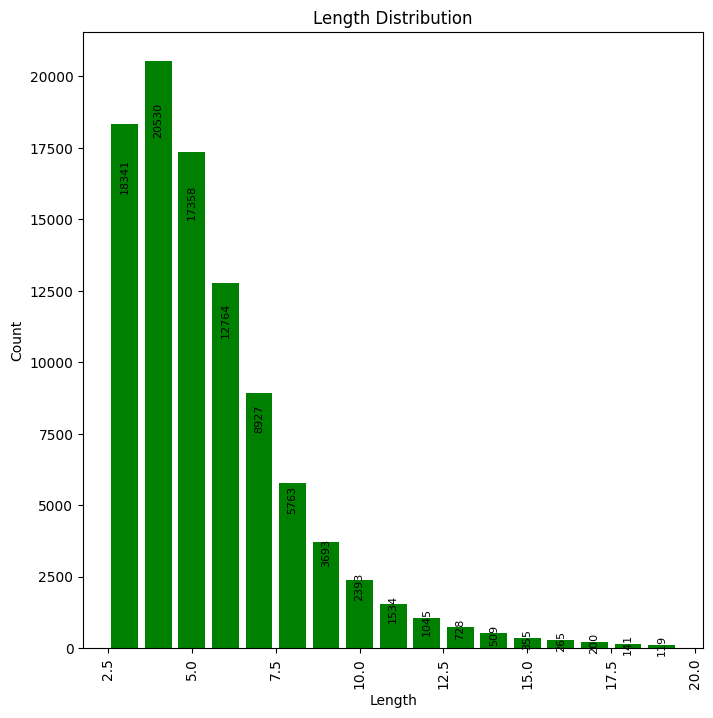

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 2) & (df_train['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

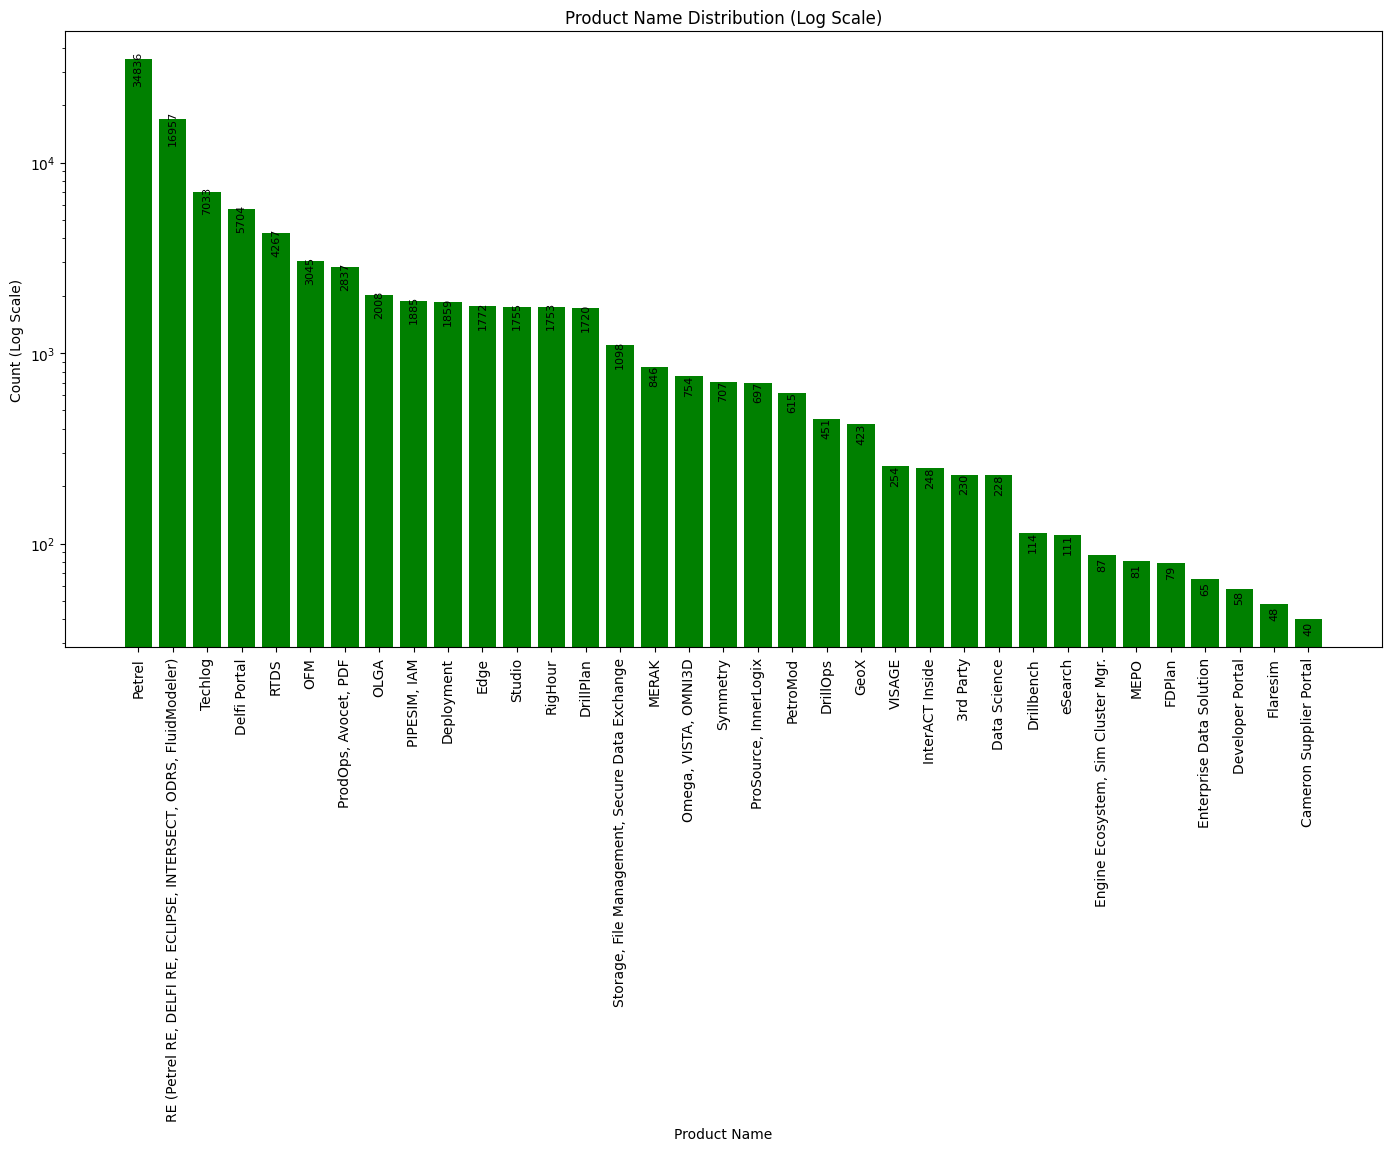

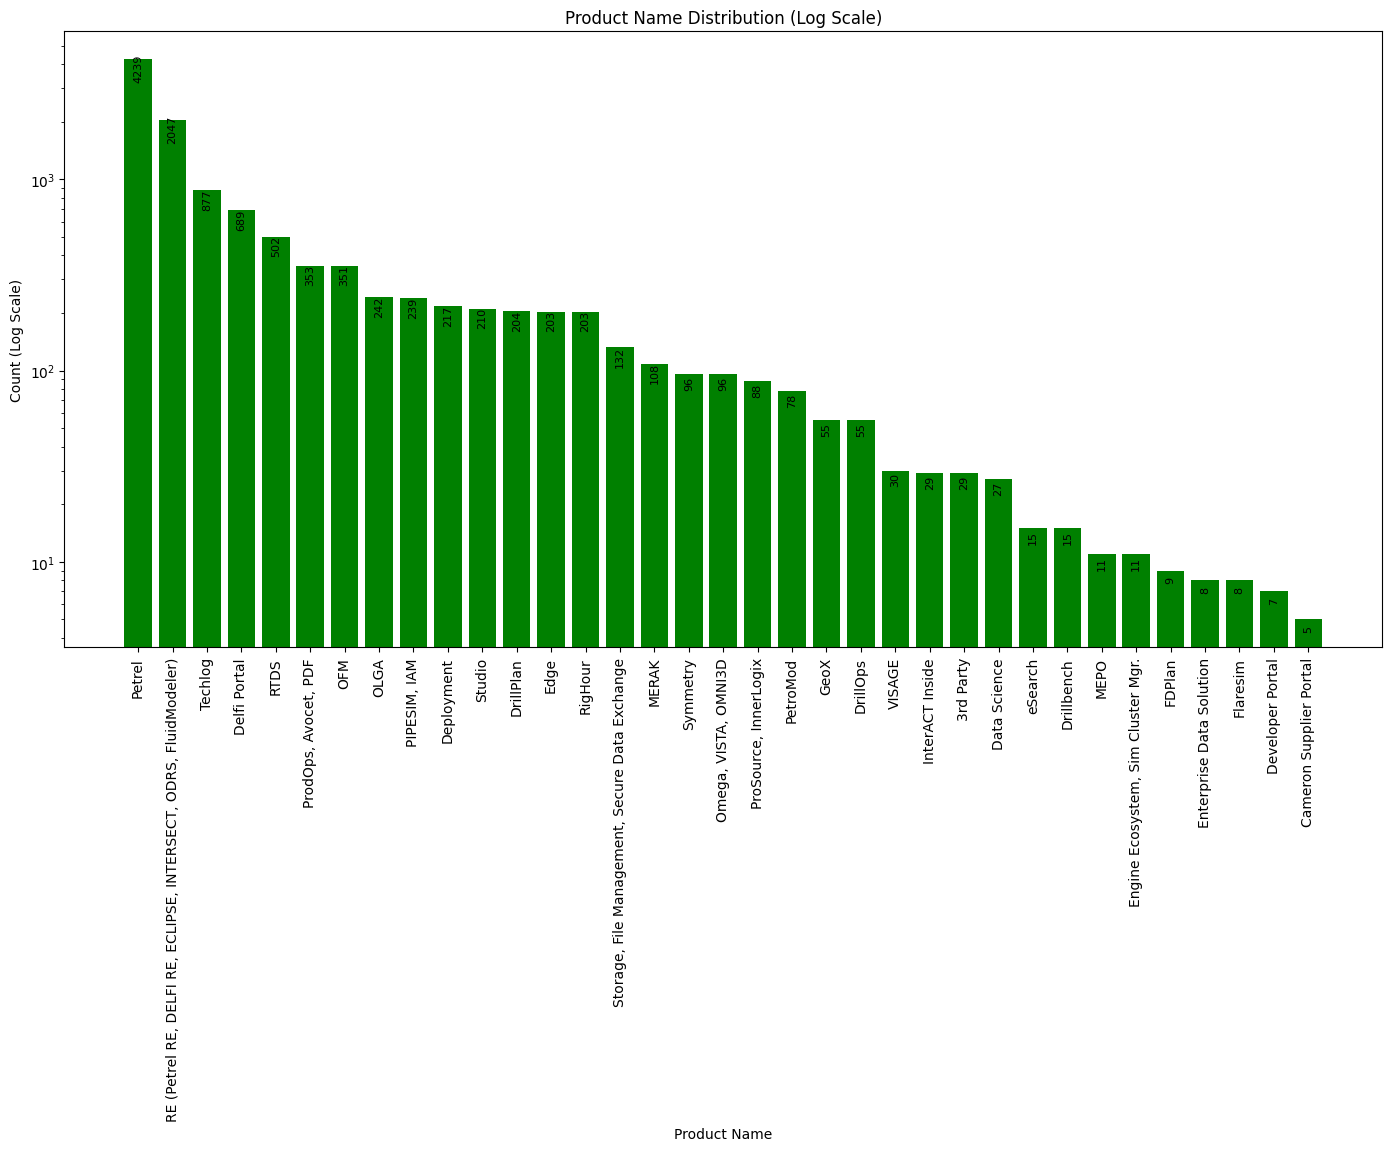

In [4]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

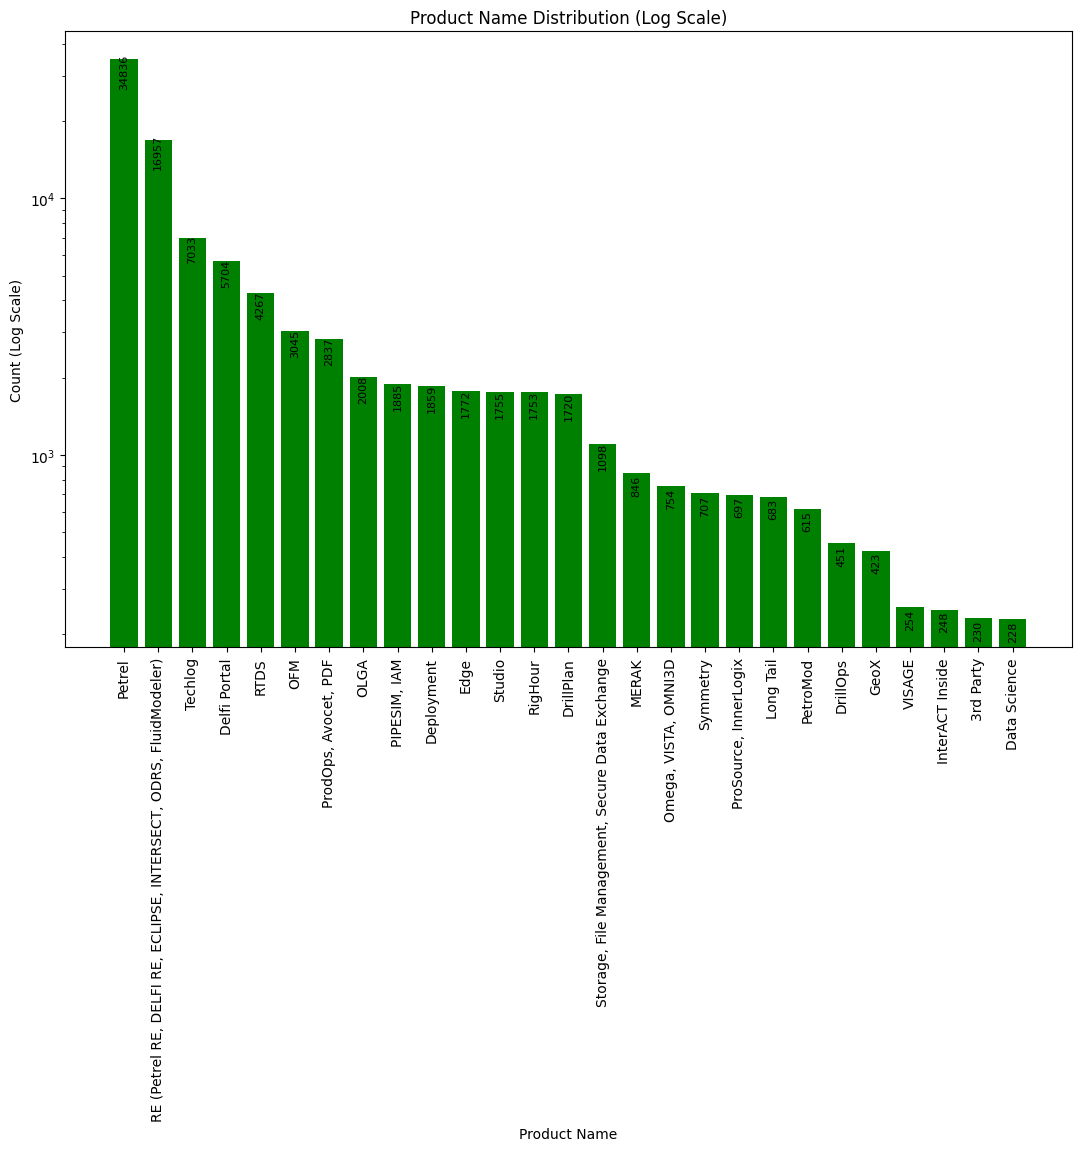

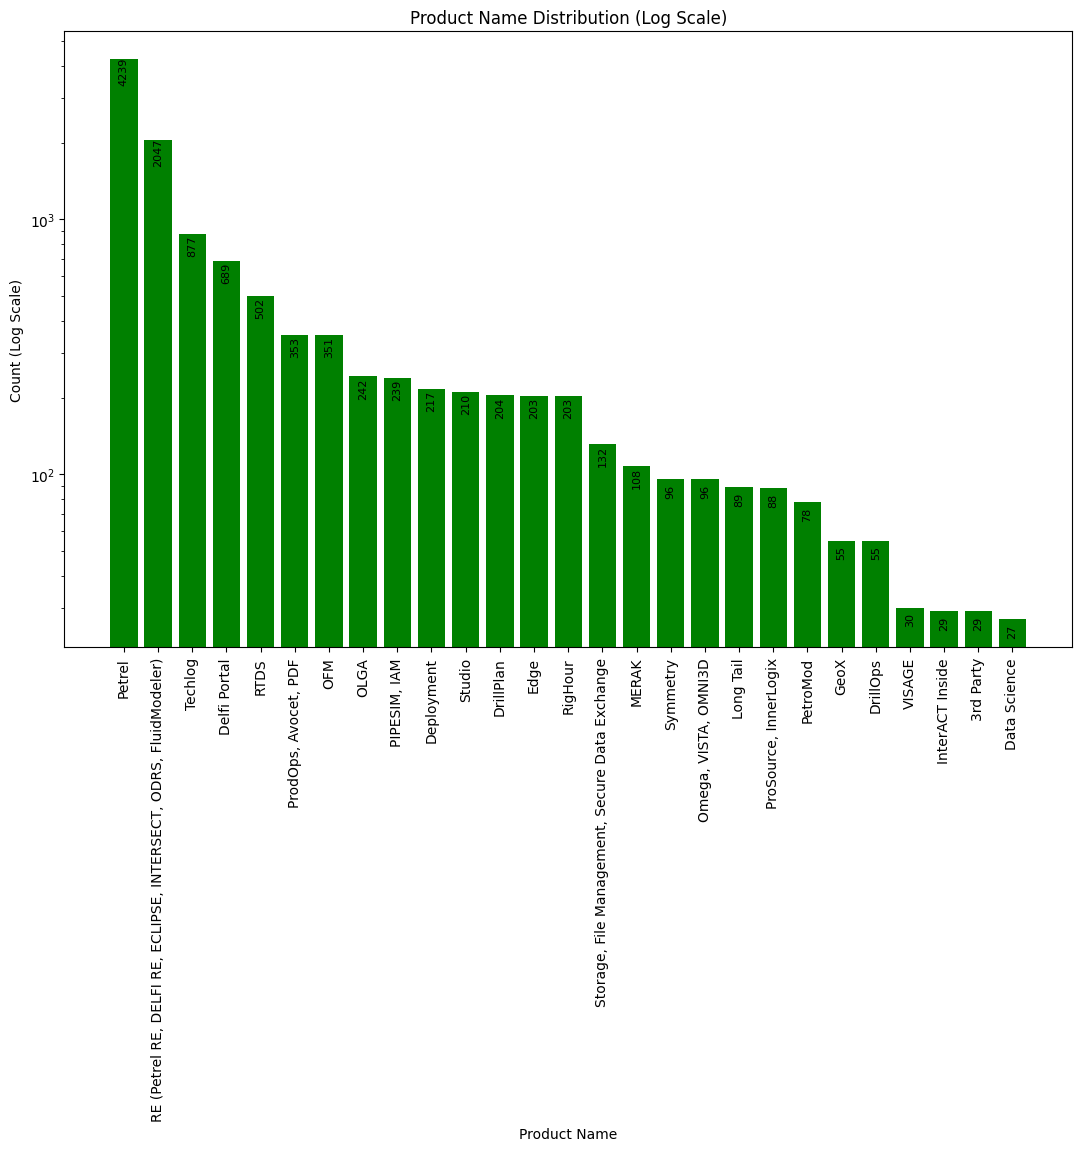

In [5]:
# Keep the top 50 products and combine the rest into 'Others'
cutoff = 200

product_counts = df_train['Product Name'].value_counts()
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'

mask_others = df_test['Product Name'].isin(product_others)
df_test.loc[mask_others,'Product Name']='Long Tail'

hist_by_labels(df_train, 'Product Name', log=True)
hist_by_labels(df_test, 'Product Name', log=True)

## Balance Train and Test Data

<class 'pandas.core.frame.DataFrame'>
Index: 37486 entries, 17202 to 103149
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        37486 non-null  int64 
 1   Title             37486 non-null  object
 2   Product Name      37486 non-null  object
 3   Length            37486 non-null  int64 
 4   Language          37486 non-null  object
 5   Title_Processed   37486 non-null  object
 6   Title_Translated  37486 non-null  object
 7   Tags              37486 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.6+ MB
None


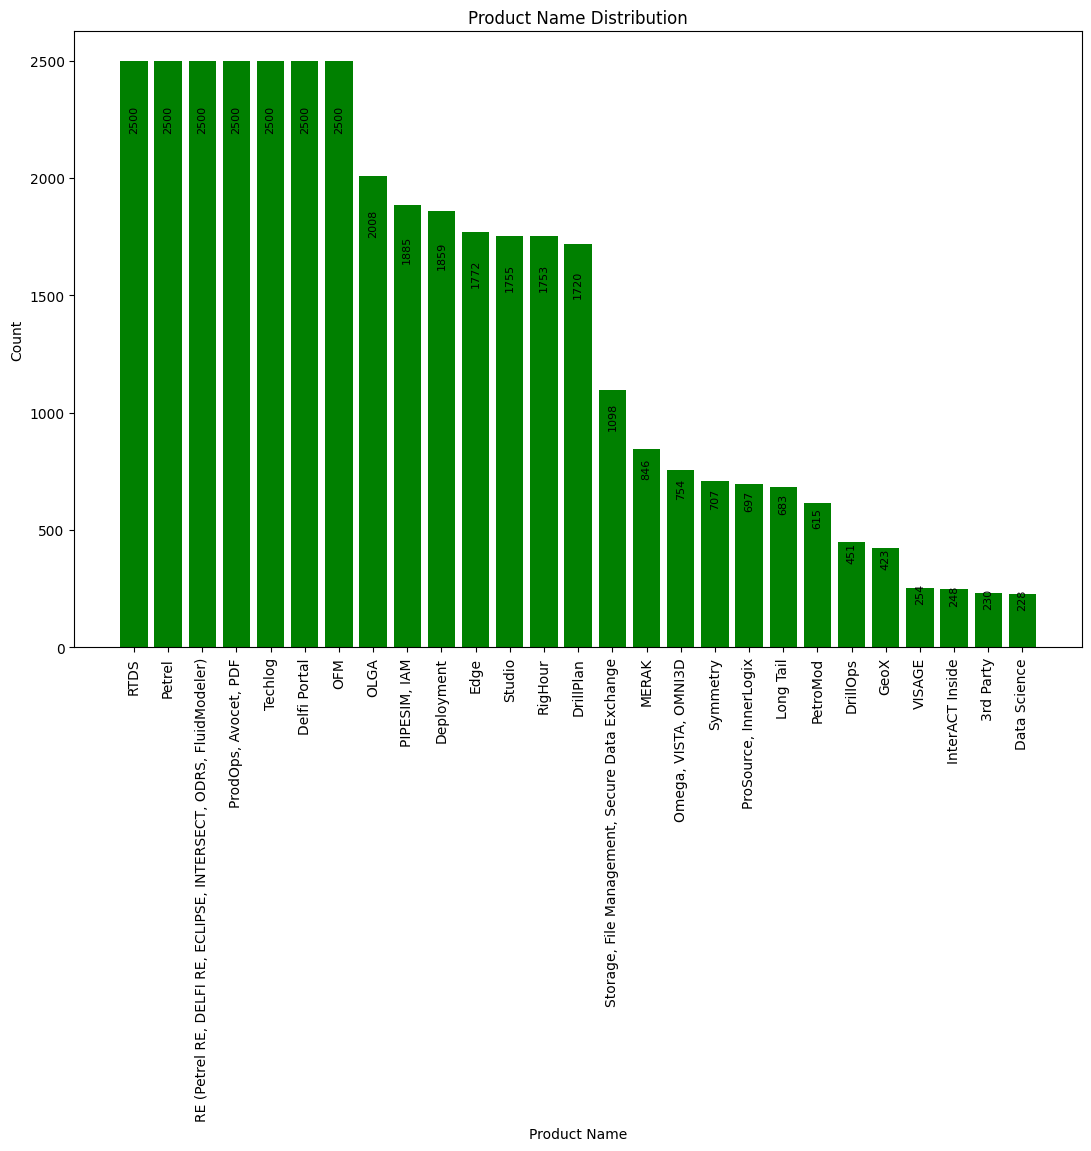

In [6]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 2500

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())

hist_by_labels(df_train_balanced, 'Product Name', log=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4880 entries, 7492 to 11460
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4880 non-null   int64 
 1   Title             4880 non-null   object
 2   Product Name      4880 non-null   object
 3   Length            4880 non-null   int64 
 4   Language          4880 non-null   object
 5   Title_Processed   4880 non-null   object
 6   Title_Translated  4880 non-null   object
 7   Tags              4880 non-null   object
dtypes: int64(2), object(6)
memory usage: 343.1+ KB
None


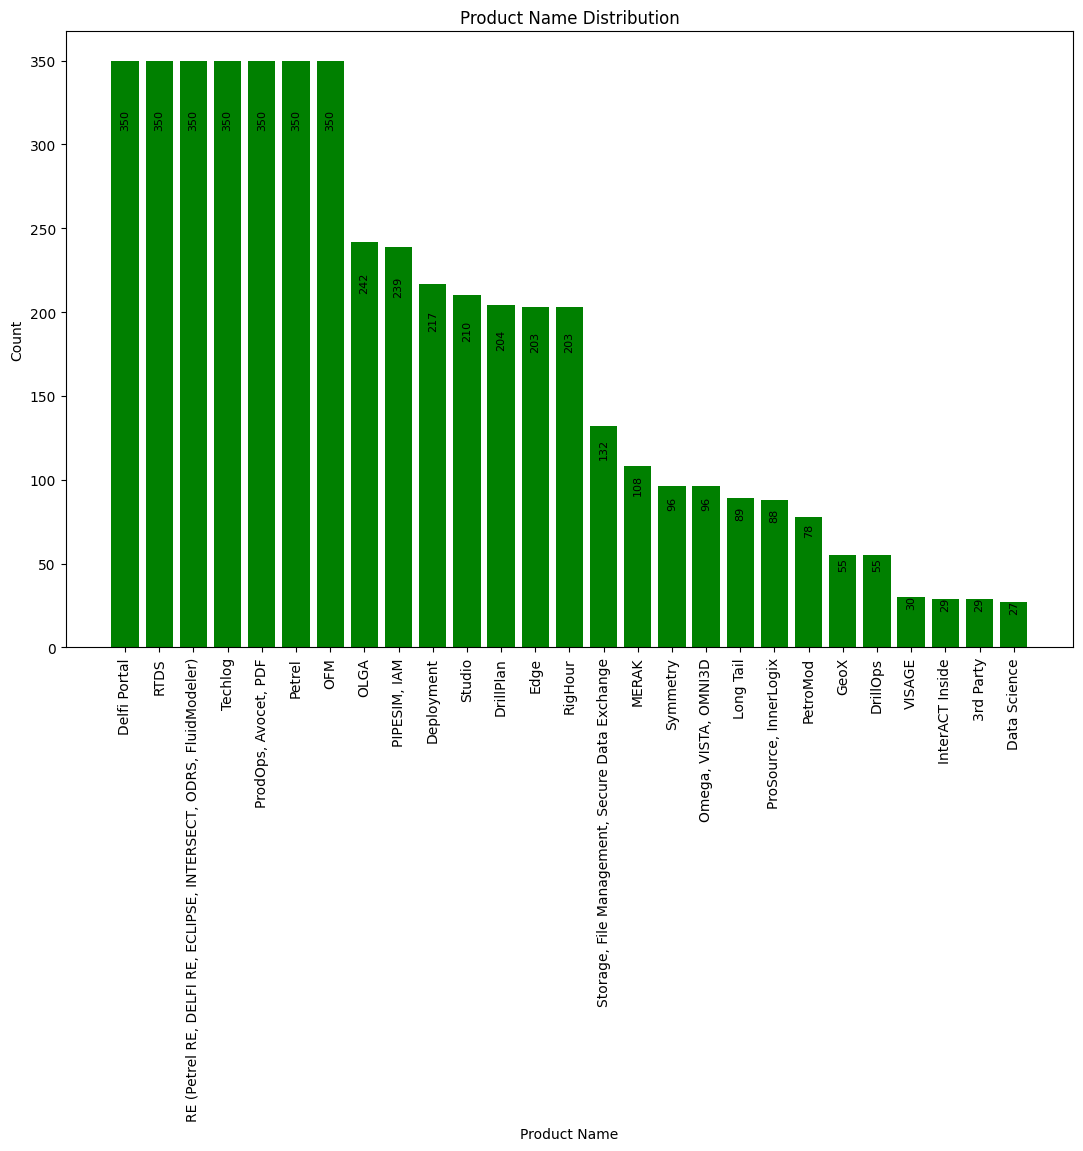

In [7]:
max_size = 350

df_test_balanced = pd.DataFrame()

for product in df_test['Product Name'].unique():
    df_product = df_test[df_test['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_test_balanced = pd.concat([df_test_balanced, df_product_balanced])

print(df_test_balanced.info())


hist_by_labels(df_test_balanced, 'Product Name', log=False)

In [8]:
df_train_balanced.head(-10)

,Request ID,Title,Product Name,Length,Language,Title_Processed,Title_Translated,Tags
17202,2532064,Viking-21: Client request horizontal depth log...,RTDS,5,en,: Client request horizontal depth log in . sec...,: Client request horizontal depth log in . sec...,client depth horizontal log section
86140,709543,SSV Catarina ENI East Sepinggan Ltd Maha Maha-...,RTDS,12,en,SSV Catarina ENI East Sepinggan Ltd Maha Dir i...,semisubmersible vessel (SSV) Catarina ENI East...,catarina dir east ltd maha section semisubmers...
30652,1628825,Ralph Coffman ENI RTDC Amoca Amoca-9DES Comple...,RTDS,18,en,Ralph Coffman ENI RTDC Amoca Completion DST Ti...,Ralph Coffman ENI real time drilling center (R...,amoca bit center coffman completion dbtm depth...
66776,874001,Jindal Pioneer ENI RTDC Mizton Mizton-8DES 30i...,RTDS,17,en,Jindal Pioneer ENI RTDC Mizton x XCD Time ML D...,Jindal Pioneer ENI real time drilling center (...,bit center dbtm depth drill drilling jindal le...
80106,2273316,Jindal Pioneer ENI RTDC Mizton Mizton-7REE Com...,RTDS,19,en,Jindal Pioneer ENI RTDC Mizton Completion Comp...,Jindal Pioneer ENI real time drilling center (...,bit center completion dbtm depth drill drillin...
...,...,...,...,...,...,...,...,...
100972,1458737,[Ext] GeoX 2021.2- questions about consistency...,GeoX,4,en,Ext GeoX . questions about consistency check,Ext GeoX . questions about consistency check,check consistency geox questions
101197,273378,[Ext] Inquietud arboles geox múltiples proyectos,GeoX,5,es,Ext Inquietud arboles geox múltiples proyectos,Ext Concern geox trees multiple projects,concern geox multiple projects trees
101252,2102412,[Ext] GeoX fails to connect to the DB in the n...,GeoX,6,en,Ext GeoX fails to connect to the DB in the new...,Ext GeoX fails to connect to the database in t...,connect database enviroment fails geox test
101300,2271988,Need to launch GeoX. Will not launch from Delf...,GeoX,5,en,Need to launch GeoX. Will not launch from Delf...,Need to launch GeoX . Will not launch from Del...,delfi free geox launch licenses


In [9]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

column_name_train = 'Title_Translated'
column_name_test = 'Title_Translated'

X = df_train[column_name_train]

vectorizer_countvec = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_countvec.fit(X)

vectorizer_tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(X)

X_train = df_train_balanced[column_name_train]
y_train = df_train_balanced['Product Name']

X_test = df_test_balanced[column_name_test]
y_test = df_test_balanced['Product Name']

X_train_countvec = vectorizer_countvec.transform(X_train)
X_test_countvec = vectorizer_countvec.transform(X_test)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# vectorizer = vectorizer_countvec
# X_train_encoded = X_train_countvec
# X_test_encoded = X_test_countvec

# vectorizer = vectorizer_tfidf
# X_train_encoded = X_train_tfidf
# X_test_encoded = X_test_tfidf

# Model Baseline - Cross Validation

In [10]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pickle

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        # X_train_countvec,
        X_train_tfidf,
        # X_train_glove,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

# Hpyerparameter Tuning

## SGC Classifier

In [ ]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=150, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_tfidf, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification

In [ ]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 10000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer_countvec, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_countvec, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_countvec, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1, 1.2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=20, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)

In [ ]:
vis.plot_optimization_history(study)

In [ ]:
vis.plot_slice(study)

In [ ]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('svc_linear', best_model_svc_linear)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

Using TensorFlow backend
Tensorflow version: 2.14.0
KerasNLP version: 0.6.2


In [12]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [14]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

2023-10-27 20:50:51.712337: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-10-27 20:50:51.712366: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-27 20:50:51.712372: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-27 20:50:51.712404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-27 20:50:51.712420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 27)                             │          20,763 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,974,235 (255.49 MB)

 Trainable params: 66,974,235 (255.49 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

Epoch 1/3


2023-10-27 20:51:07.228149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  1/938 [..............................] - ETA: 15:59:56 - loss: 3.3267 - accuracy: 0.0312

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')